# Cats vs dogs kaggle challenge - Transfer learning

In [2]:
# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import preprocessing

# categorical
from tensorflow.keras.utils import to_categorical

# model
from tensorflow.keras.models import Sequential

# layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Flatten, Dense, BatchNormalization, Dropout

# callbacks
from tensorflow.keras.callbacks import EarlyStopping

# backend
from tensorflow.keras import backend as K

# other
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

### Reading in data

In [2]:
def prep_data(path, img_dim, total_pics=1_000):
    X = []
    y = []
    count = 0
    
    for p in os.listdir(path):
        count += 1
        category = p.split(".")[0]
        img = image.load_img(path+p, target_size=(img_dim, img_dim))
        img_array = image.img_to_array(img)
        img_array = img_array.astype(np.uint8)
        X.append(img_array)
        if category == 'dog':
            y.append(1)
        else:
            y.append(0)
        if count >= total_pics:
            break
    X_array = np.array(X)
    y_array = np.array(y)
    return X_array, y_array

In [3]:
img_dim = 224
path = "data/train/"
X, y = prep_data(path, img_dim, total_pics=1_000)

In [4]:
X.shape, y.shape

((1000, 224, 224, 3), (1000,))

array([0])

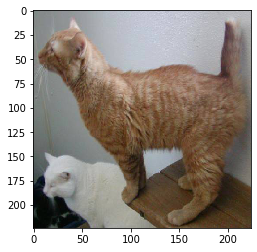

In [23]:
check = 45
plt.imshow(X[check])
y[check]

In [6]:
sum(y)

498

### Preprocessing

In [7]:
# reshape data
y = y.reshape(y.shape + (1,))

In [8]:
# normalize the data
X = X/255 

In [9]:
X.shape, y.shape

((1000, 224, 224, 3), (1000, 1))

In [10]:
X.dtype

dtype('float64')

In [11]:
X.max(), X.min()

(1.0, 0.0)

### Train-test split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((800, 224, 224, 3), (200, 224, 224, 3), (800, 1), (200, 1))

### Define plotting functions

In [13]:
# summarize history for accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [14]:
# summarize history for loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Build the model

In [15]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

In [16]:
K.clear_session()

In [17]:
model = Sequential()
model.add(MobileNet(include_top=False, pooling='max', input_shape=(img_dim, img_dim, 3)))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


In [19]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

### Fit model (last dense layer)

In [20]:
# fit the model
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=10,
                    epochs=10, 
                    validation_split=0.2,
)

Epoch 1/10
64/64 [==============================] - 17s 258ms/step - loss: 0.8406 - accuracy: 0.7063 - val_loss: 0.4191 - val_accuracy: 0.8188
Epoch 2/10
64/64 [==============================] - 15s 241ms/step - loss: 0.2977 - accuracy: 0.9125 - val_loss: 0.3691 - val_accuracy: 0.8938
Epoch 3/10
64/64 [==============================] - 15s 241ms/step - loss: 0.1947 - accuracy: 0.9297 - val_loss: 0.3898 - val_accuracy: 0.8938
Epoch 4/10
64/64 [==============================] - 15s 242ms/step - loss: 0.1541 - accuracy: 0.9438 - val_loss: 0.2628 - val_accuracy: 0.9312
Epoch 5/10
64/64 [==============================] - 16s 245ms/step - loss: 0.1018 - accuracy: 0.9500 - val_loss: 0.1874 - val_accuracy: 0.9250
Epoch 6/10
64/64 [==============================] - 16s 247ms/step - loss: 0.0970 - accuracy: 0.9625 - val_loss: 0.1876 - val_accuracy: 0.9312
Epoch 7/10
64/64 [==============================] - 16s 250ms/step - loss: 0.0582 - accuracy: 0.9766 - val_loss: 0.1676 - val_accuracy: 0.9312

### Plot loss and accuracy

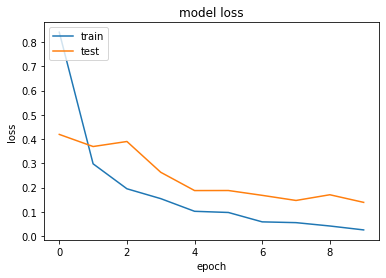

In [21]:
plot_loss(history)

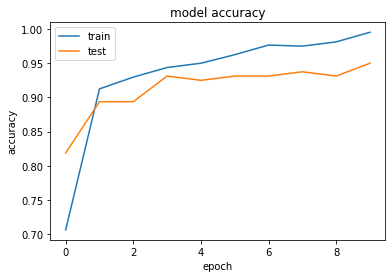

In [22]:
plot_accuracy(history)

In [25]:
model.evaluate(X_val, y_val)

7/7 [==============================] - 3s 473ms/step - loss: 0.1806 - accuracy: 0.9250


[0.18063586950302124, 0.925000011920929]

### Which images did it get wrong?

In [28]:
y_pred = model.predict(X_val).round()

In [86]:
false_preds = list(i[0] == i[1] for i in zip(y_pred, y_val))

In [88]:
false_preds_positions = []

for i, pred in enumerate(false_preds):
    if pred == False:
        false_preds_positions.append(i)

In [89]:
false_preds_positions

[2, 6, 27, 33, 42, 68, 76, 89, 123, 128, 157, 179, 192, 194, 197]

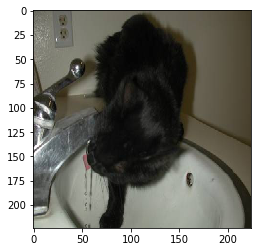

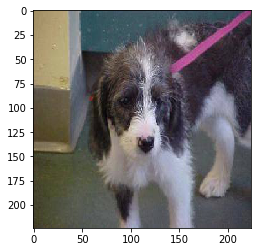

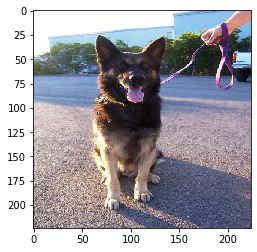

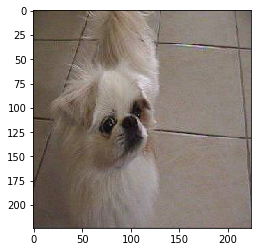

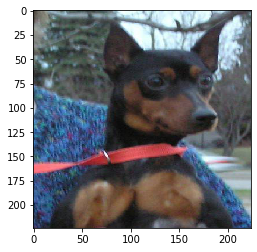

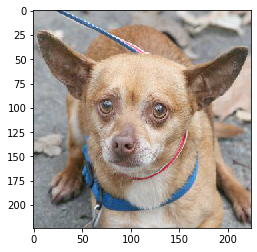

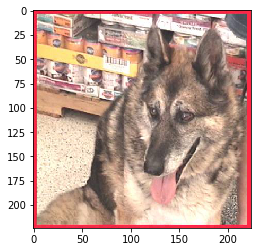

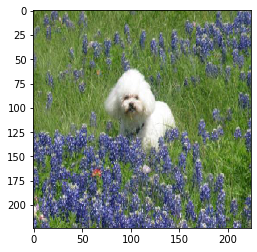

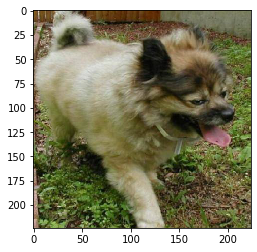

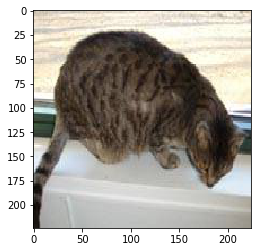

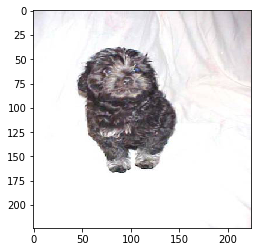

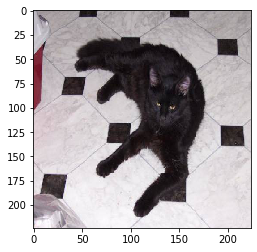

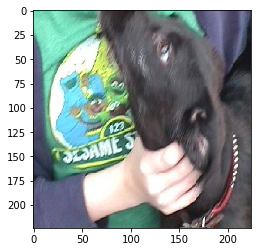

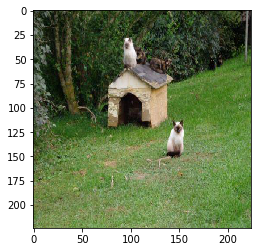

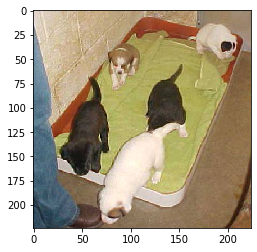

In [84]:
for i in false_preds_positions:
    plt.imshow(X_val[i])
    plt.show()

### Takeaways:
- trouble-shooting / optimizing self-built NNs is super complicated
- transfer learning is super powerful
- animals are no digits